In [ ]:
### -------------------------- 生信分析基础 ------------------------------ ###
## contact: fuxin@singleronbio.com
## 单细胞基础分析：Seurat

In [4]:
library(tidyverse)
library(Seurat)
library(ggplot2)

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching SeuratObject



In [1]:
outdir = "/SGRNJ03/randd/user/fuxin/PROJECTS/Bioinfo_Train/results"
sample = "PYF"

In [2]:
#读入10x格式矩阵
matrix_file = "/SGRNJ03/randd/user/fuxin/PROJECTS/Bioinfo_Train/PYF/PYF-wta_filtered_feature_bc_matrix"
matrix= Seurat::Read10X(matrix_file, gene.column = 2) #dgCMatrix

In [5]:
#构建Seurat对象
rds = CreateSeuratObject(matrix, project=sample,min.cells = 5,min.features = 50)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


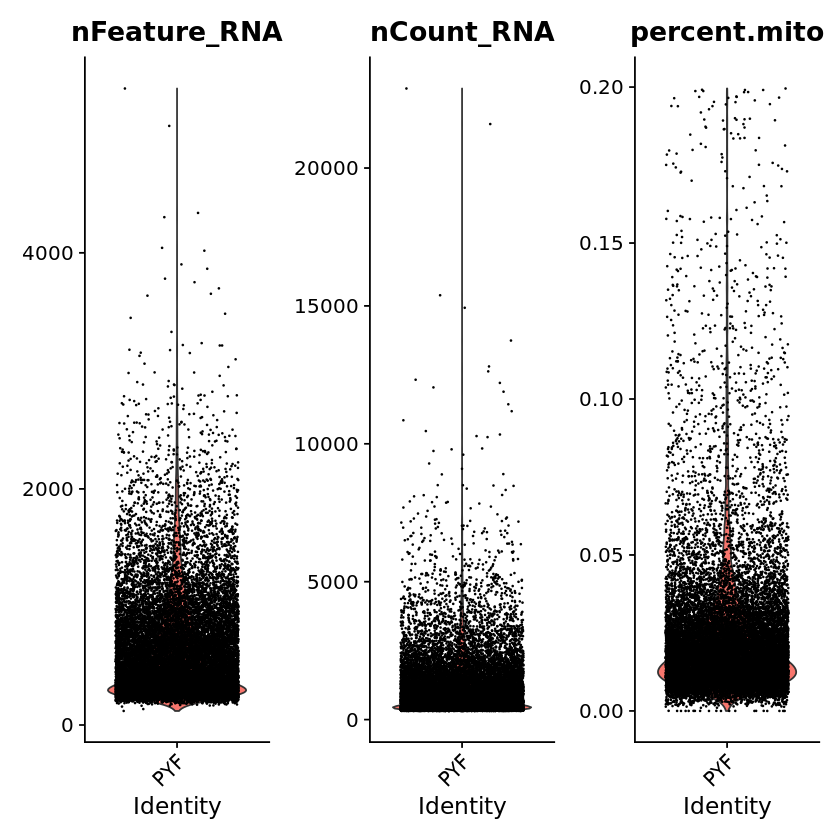

In [6]:
#质量控制
all_genes = rownames(rds@assays$RNA@data)
mito.genes <- grep(pattern = "^MT-", x = all_genes, value = TRUE, ignore.case=TRUE)
percent.mito <- Matrix::colSums(rds@assays$RNA@counts[mito.genes,,drop=FALSE])/Matrix::colSums(rds@assays$RNA@counts)
rds <- AddMetaData(object = rds, metadata = percent.mito, col.name = "percent.mito")
#VlnPlot(object = rds, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"), ncol = 3, pt.size = 0.1)

rds = subset(rds, percent.mito<0.2)
VlnPlot(object = rds, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"), ncol = 3, pt.size = 0.1)

In [7]:
# 标准化
rds <- NormalizeData(rds, normalization.method = "LogNormalize",scale.factor = 10000)
nfeatures = 2000
rds <- FindVariableFeatures(rds, selection.method = "vst", nfeatures = nfeatures, mean.cutoff = c(0.1, 8), dispersion.cutoff = c(1, Inf),
                            mean.function = ExpMean, dispersion.function = LogVMR)

In [8]:
#scale
use.genes <- rds@assays$RNA@var.features
rds <- ScaleData(rds, vars.to.regress = c("nCount_RNA", "percent.mito"), features = use.genes)

Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix



In [9]:
#降维聚类
rds <- RunPCA(object = rds, features = use.genes, do.print = FALSE)
rds <- FindNeighbors(rds, dims = 1:20, force.recalc = TRUE, reduction = "pca")
rds <- FindClusters(rds, resolution = 1)

PC_ 1 
Positive:  Thbs1, Wfdc17, Ctsl, Tgfbi, Ptgs2, Lrp1, Serpinh1, Lyz2, Pla2g7, Psap 
	   Slpi, Pcolce, Ctss, Acod1, S100a8, S100a9, Cd63, Adamts1, Ms4a6c, Ecm1 
	   Sdc4, Klf4, Fcgr2b, Cald1, Fn1, Cavin3, Sparc, Cxcl1, Cd9, Ctsb 
Negative:  Nkg7, Ms4a4b, Gzmb, Trbc2, Thy1, Trac, Cd3g, Cd3d, Ptprcap, AW112010 
	   Cd3e, Ifng, Lck, Il2rb, Klrc1, Prf1, Serpinb6b, Cd2, Klrd1, Klrc2 
	   Sh2d2a, Cd8a, Lag3, Rgs16, Pclaf, Ctla4, Rps15a, Gimap4, Ets1, Arsb 
PC_ 2 
Positive:  Ctss, Ms4a6c, Tgfbi, Cd74, Psap, H2-Aa, H2-Ab1, Aif1, Ctsc, Ms4a6d 
	   Cybb, H2-Eb1, Lyz2, H2-Ea-ps, Lgmn, H2-DMa, Mpeg1, Plbd1, Mafb, Fcgr2b 
	   Gpx1, Clec4a2, Gm2a, Cfp, Msr1, Clec4a3, Fcgr4, Clec4a1, Grn, Ifi30 
Negative:  Serpinh1, Pcolce, Adamts1, Cald1, Cavin3, Sparc, Hmga2, Tm4sf1, Efemp1, Aqp5 
	   Fbln2, Igfbp4, Cd63, Cav1, Crabp2, Cavin1, Htra1, Ly6c1, Ccn1, Grem1 
	   Mt2, Lamb1, Cttn, Prrx1, Ereg, Hspb8, Rhox5, Twist1, Dcn, Sdc2 
PC_ 3 
Positive:  S100a9, S100a8, Acod1, G0s2, Retnlg, Ccl3, Cxcl3, Slpi, C

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19534
Number of edges: 657406

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8294
Number of communities: 19
Elapsed time: 4 seconds


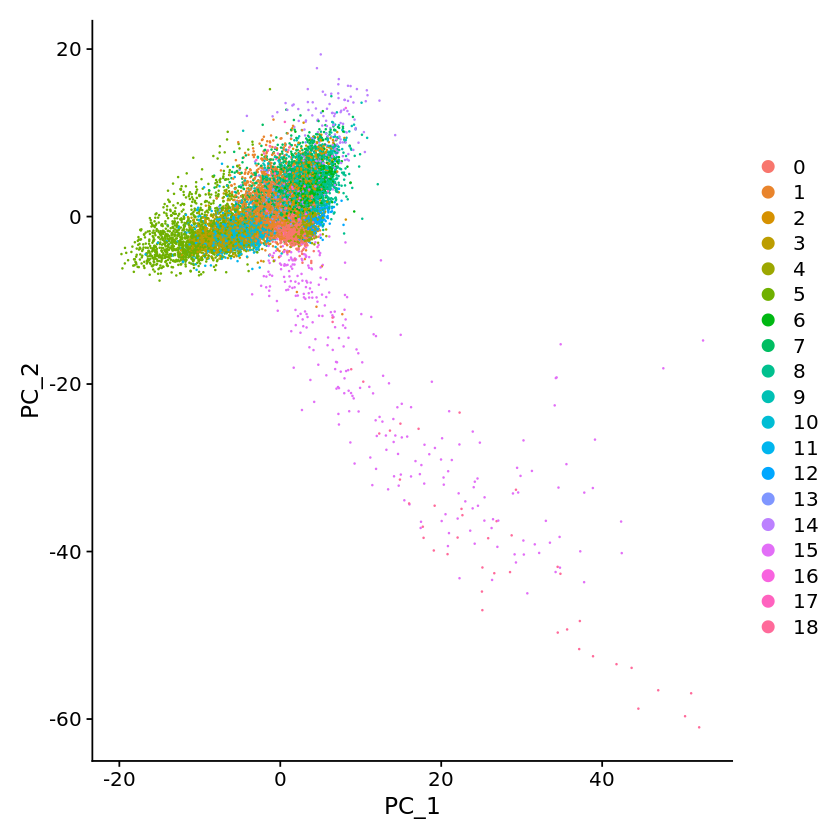

In [10]:
DimPlot(rds,reduction = "pca")->p
#p_file <- paste0(outdir,"/",sample,".pca.pdf")
#ggsave(p_file,p)
p

In [11]:
rds <- RunTSNE(rds, dims = 1:20, do.fast = TRUE, check_duplicates = FALSE)

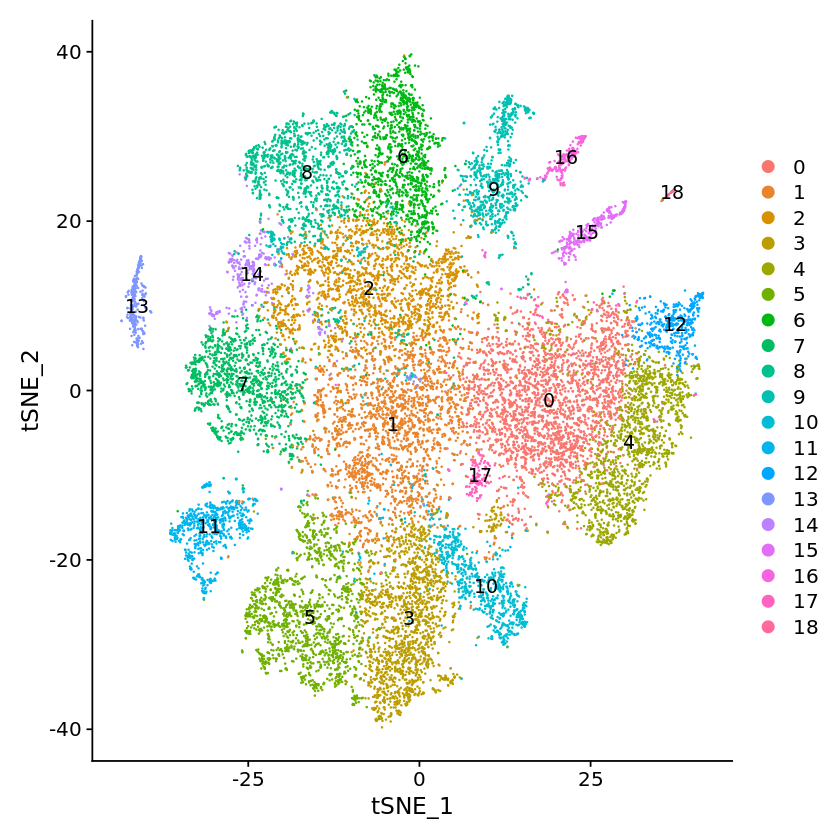

In [12]:
DimPlot(rds,reduction = "tsne",label = TRUE)->p
#p_file <- paste0(outdir,"/",sample,".tsne.pdf")
#ggsave(p_file,p,width = 7.5)
p

In [13]:
rds = RunUMAP(rds, dims=1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:43:14 UMAP embedding parameters a = 0.9922 b = 1.112

14:43:14 Read 19534 rows and found 20 numeric columns

14:43:14 Using Annoy for neighbor search, n_neighbors = 30

14:43:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:43:18 Writing NN index file to temp file /tmp/Rtmp8T0vTu/file31fa739ac10

14:43:18 Searching Annoy index using 1 thread, search_k = 3000

14:43:27 Annoy recall = 100%

14:43:27 Commencing smooth kNN distance calibration using 1 thread

14:43:29 Initializing fro

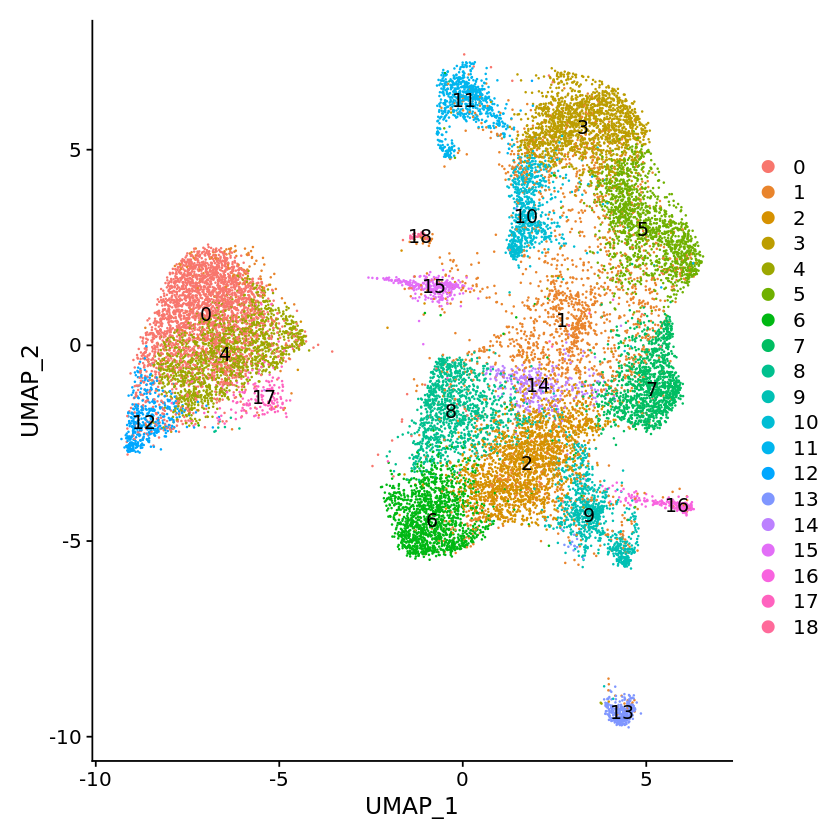

In [14]:
DimPlot(rds,reduction = "umap",label = TRUE)->p
#p_file <- paste0(outdir,"/",sample,".umap.pdf")
#ggsave(p_file,p,width = 7.5)
p

In [ ]:
saveRDS(rds, paste0(outdir,"/",sample,".rds"))

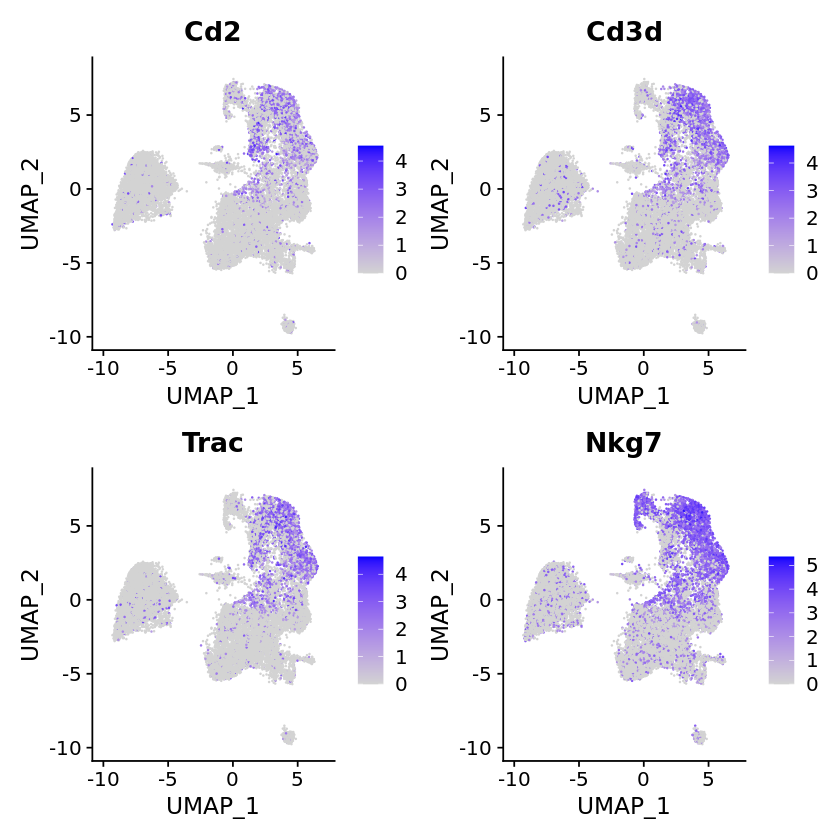

In [15]:
# 基因表达的细胞丰度图
# T cell marker gene: "CD2","CD3D","TRAC","NKG7"
FeaturePlot(rds,features = c("Cd2","Cd3d","Trac","Nkg7"),ncol = 2,reduction = "umap")->p
#p_file = paste0(outdir,"/",sample,".t_marker_4.pdf")
#ggsave(p_file,p,width = 8,height = 8)
p

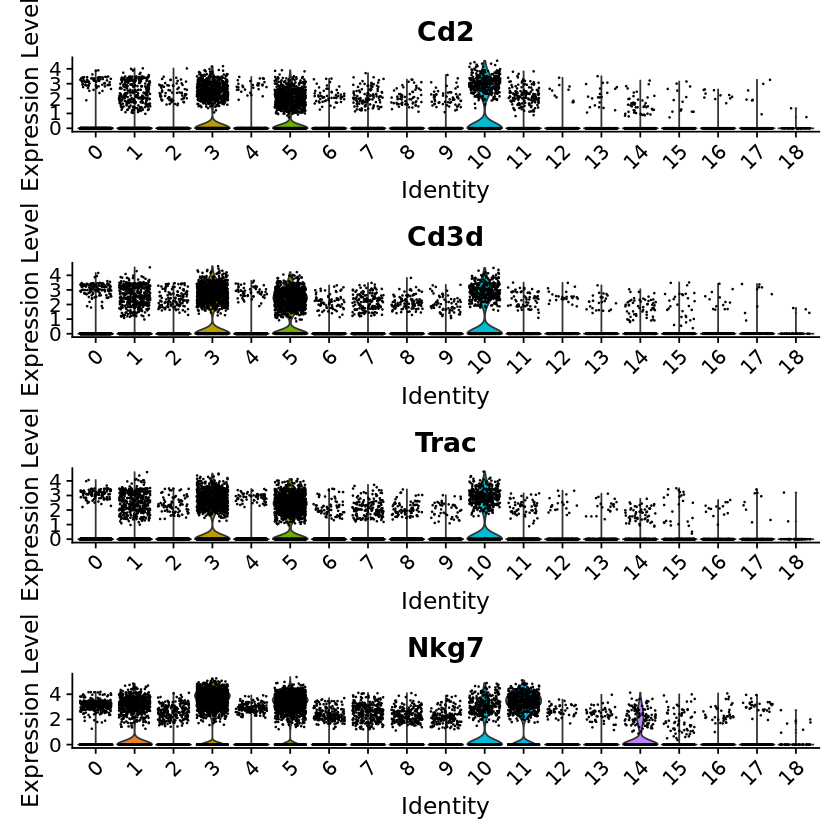

In [16]:
#基因表达量的小提琴图
VlnPlot(object = rds, features = c("Cd2","Cd3d","Trac","Nkg7"), ncol = 1, pt.size = 0.1)->p
p_file = paste0(outdir,"/",sample,".t_marker_4.vln.pdf") #cluster10 是 T cells
ggsave(p_file,p,width = 10,height = 10)
p

In [33]:
#markers = FindAllMarkers(rds)
markers_top5 = markers%>%
    group_by(cluster)%>%
    top_n(n = 5,wt = avg_log2FC) #取每个cluster显著性前10的marker

In [36]:
markers_file = paste0(outdir,"/",sample,".allmarkers.tsv")
markers_file_top5 = paste0(outdir,"/",sample,".top5markers.tsv")
#readr::write_tsv(markers,markers_file)
readr::write_tsv(markers_top5,markers_file_top5)

Warning message in DoHeatmap(object = rds, features = unique(markers_top5$gene)):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: mt-Rnr1, Gm42418, Cxcl2, Hdc, Hcar2”


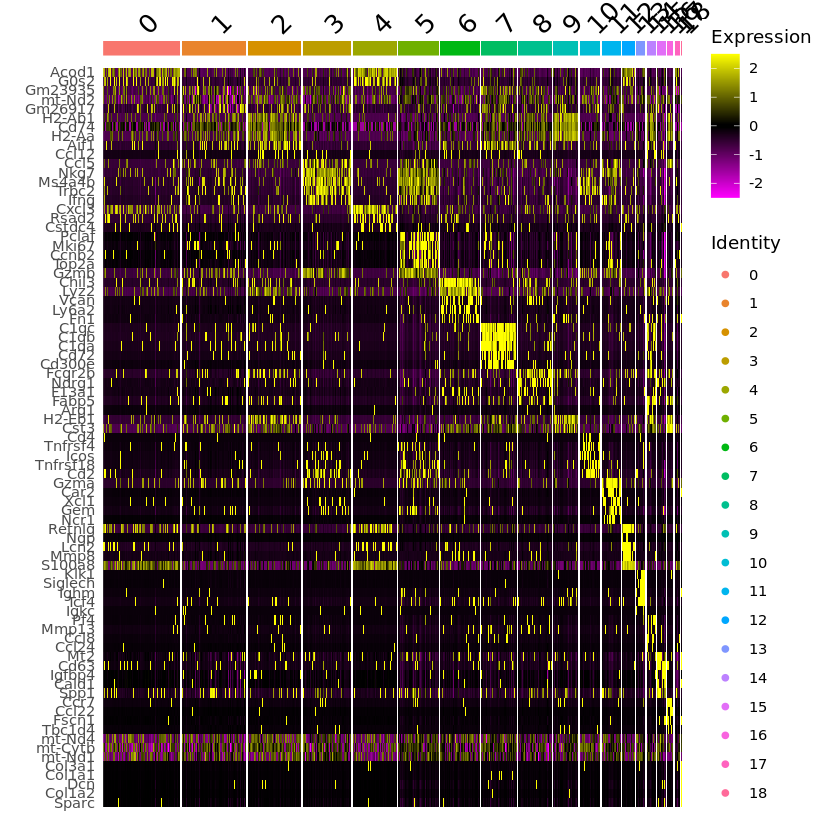

In [35]:
# marker基因的热图
DoHeatmap(object = rds,features = unique(markers_top5$gene)) ->p
#p_file = paste0(outdir,"/",sample,".heatmap.markertop5.pdf")
#ggsave(p_file,p, width = 12,height = 12 )
p

In [37]:
# 整合tag数据
tag_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/PYF/04.count_tag/hashing_umi_tag.tsv"
tag_df = read.table(tag_file,header = TRUE)

In [38]:
tag_df$cell_ident = rownames(tag_df)
data.frame(cell_ident = Cells(rds), clusters = rds$`RNA_snn_res.1`)%>%
    left_join(tag_df)-> tag_df
rownames(tag_df) <- tag_df$cell_ident
tag_df$tag <- factor(tag_df$tag,levels = c("Multiplet","tag1","tag3","tag4","tag5","Undetermined"))

Joining, by = "cell_ident"



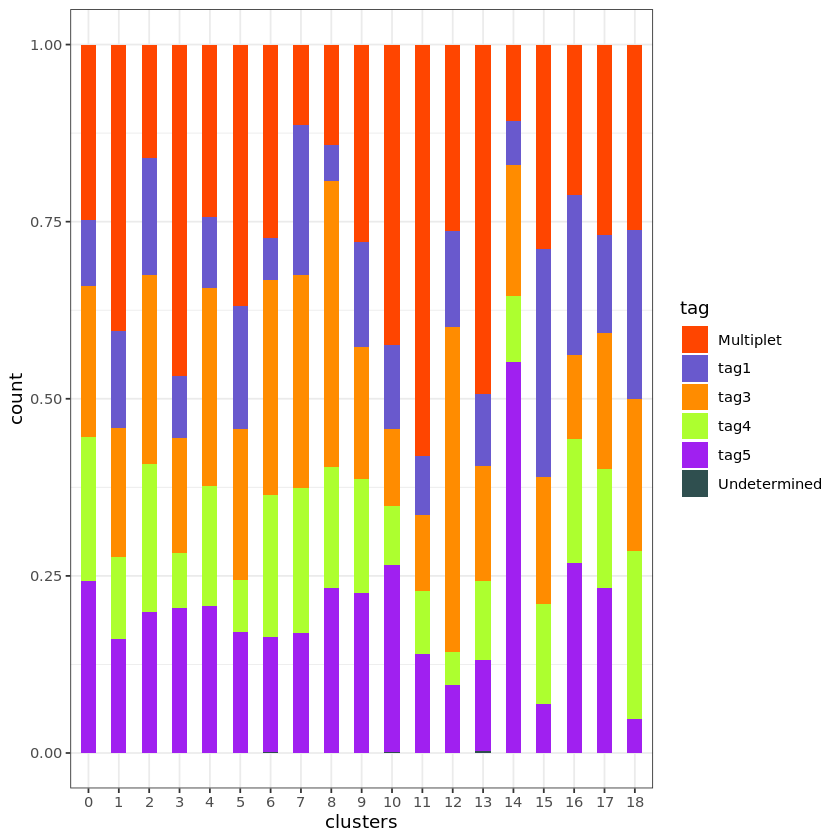

In [39]:
ggplot(tag_df,aes(x = clusters, fill = tag))+
    geom_bar(position = "fill",width = 0.5)+
    scale_fill_manual(values = c("OrangeRed","SlateBlue3","DarkOrange","GreenYellow","Purple","DarkSlateGray"))+
    theme_bw()->p
#p_file = paste0(outdir,"/",sample,".tag_fraction.pdf")
#ggsave(p_file,p,width = 10,height = 4.5)
p

In [40]:
rds <- AddMetaData(rds, tag_df%>%dplyr::select(-cell_ident, -clusters))

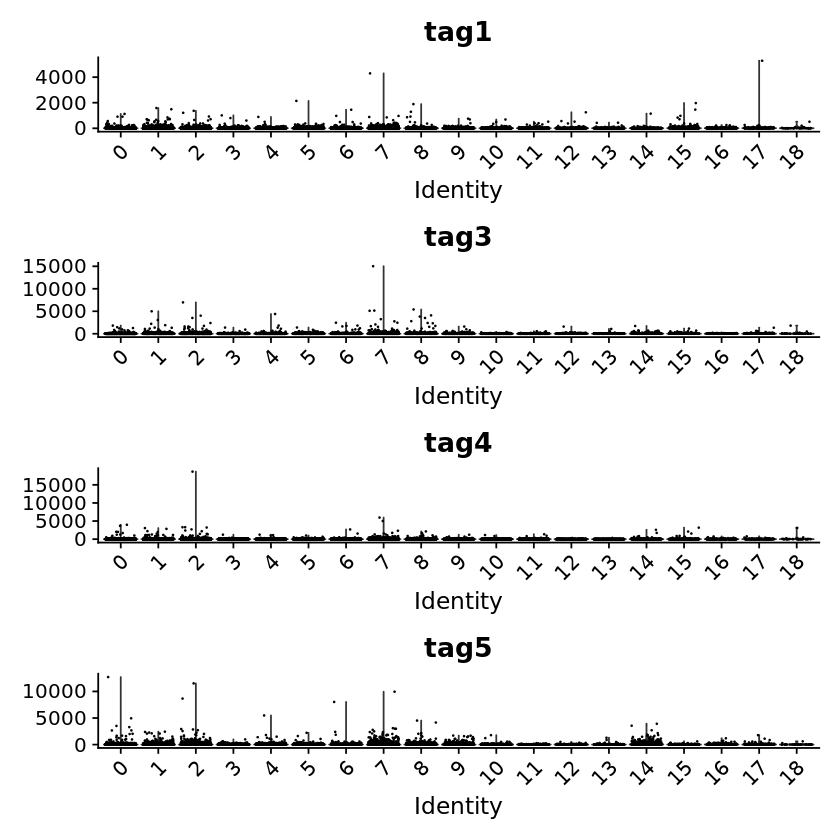

In [41]:
VlnPlot(object = rds, features = c("tag1", "tag3", "tag4","tag5"), ncol = 1, pt.size = 0.1)->p
#p_file = paste0(outdir,"/",sample,".vln.tag.pdf")
#ggsave(p_file,p, width = 8, height = 8)
p

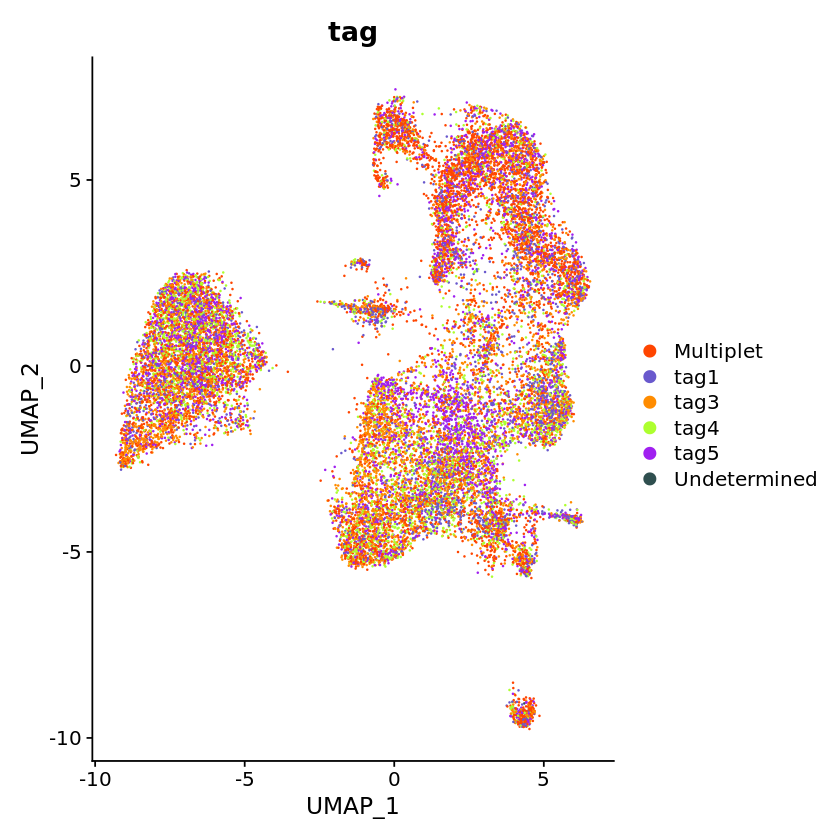

In [43]:
DimPlot(rds, reduction = "umap", group.by = "tag",
        cols = c("OrangeRed","SlateBlue3","DarkOrange","GreenYellow","Purple","DarkSlateGray"))->p
#p_file = paste0(outdir,"/",sample,".umap.tag.pdf")
#ggsave(p_file,p, width = 8)
p

In [44]:
str(rds)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:12296215] 0 5 24 43 70 80 120 129 156 161 ...
  .. .. .. .. .. ..@ p       : int [1:19535] 0 262 1385 1894 2842 3119 5195 6258 6578 6799 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 16776 19534
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:16776] "Gnai3" "Cdc45" "H19" "Narf" ...
  .. .. .. .. .. .. ..$ : chr [1:19534] "AAACATCGAACAACCAAAGACGGA" "AAACATCGAACAACCAAATCCGTC" "AAACATCGAACAACCAACCTCCAA" "AAACATCGAACAACCAGCTCGGTA" ...
  .. .. .. .. .. ..@ x       : num [1:12296215] 1 2 1 1 1 1 6 3 1 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:12296215] 0 5 24 43 7